![](/images/blog/knight-dialer.png)

This week, a friend showed me the [knight dialer coding problem](https://leetcode.com/problems/knight-dialer/). As usual, I couldn't resist framing it as a graph exploration problem - read on to see how I tackled it.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gilgi/gilgi.github.com/blob/src/posts/knight_dialer.ipynb)

<!-- TEASER_END -->

In [0]:
import itertools

import numpy as np
import matplotlib.pyplot as plt

The keypad looks like this:

```
1 2 3
4 5 6
7 8 9
  0
```

We will mark the "redacted" pound and star keys with -1's so that we know they aren't real keys.

In [0]:
keypad = np.array([[ 1,  2,  3],
                   [ 4,  5,  6],
                   [ 7,  8,  9],
                   [-1,  0, -1]])
keypad

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [-1,  0, -1]])

Here are all all 8 jumps a knight can make as vectors:

In [0]:
jumps = list(map(
    sum,
    itertools.product([np.array([0, 2]), np.array([0, -2])],
                      [np.array([1, 0]), np.array([-1, 0])]))) + \
    list(map(
        sum,
        itertools.product([np.array([2, 0]), np.array([-2, 0])],
                          [np.array([0, 1]), np.array([0, -1])])))
jumps

[array([1, 2]),
 array([-1,  2]),
 array([ 1, -2]),
 array([-1, -2]),
 array([2, 1]),
 array([ 2, -1]),
 array([-2,  1]),
 array([-2, -1])]

We can construct a graph where the nodes are keys and the edges link two nodes that a knight could jump between in a single hop.

In [0]:
graph = {}
for i in range(keypad.shape[0]):
    for j in range(keypad.shape[1]):
        # these aren't real nodes
        if keypad[i, j] == -1:
            continue

        # this is the new key we are adding to the graph
        key = keypad[i, j]
        graph[key] = []

        # check each of a knight's 8 possible jumps
        for jump in jumps:
            target = np.array([i, j]) + jump
            if np.all(target < keypad.shape) and np.all(target >= 0) \
                    and keypad[tuple(target)] != -1:
                graph[key].append(keypad[tuple(target)])
graph

{0: [6, 4],
 1: [6, 8],
 2: [9, 7],
 3: [4, 8],
 4: [9, 3, 0],
 5: [],
 6: [7, 1, 0],
 7: [6, 2],
 8: [3, 1],
 9: [4, 2]}

The degree of each node/key is 2, except for the 5 key (no jumps possible) and the 4 and 6 keys (extra jump to the 0 key). If they were all 2, we could write the number of unique dials as

$$K\times 2^N$$

where $K = 10$ is the number of starting keys, $N$ is the number of jumps, and $2$ is the number of choices for each jump.

The question technically asks for the number of unique dials possible from a given starting position, which would just be

$$2^N$$

Unfortunately, since the degrees aren't actually all 2, we need a different plan. One simple idea is to use brute force: for a given initial key, we can unroll our directed cyclic graph into a tree rooted at the initial key and count the leaves at depth $N$. We can track the nodes of the tree according to the list of graph nodes (individual keys) they passed through (from the root to the leaf, in order). We technically don't need to track the identities of the leaves (since the problem asks us only to count the number of dialable numbers, not list them) but it will be more fun this way because we will get to see the numbers being dialed.

In [0]:
def find_leaves(initial_key, num_jumps):
    leaves = []
    def explore(current_node, depth=0):
        if depth == num_jumps:
            leaves.append(current_node)
        else:
            for adjacent_key in graph[current_node[-1]]:
                explore(current_node + [adjacent_key], depth=depth+1)
    explore([initial_key])
    return leaves

For example, we can check how many numbers we can dial taking $N = 3$ jumps starting from initial key 2:

In [0]:
leaves = find_leaves(2, 3)
len(leaves), list(map(lambda x: ''.join(map(str, x)), leaves))

(10,
 ['2949',
  '2943',
  '2940',
  '2929',
  '2927',
  '2767',
  '2761',
  '2760',
  '2729',
  '2727'])

We can do some sanity checks here:

 1. All the dialed numbers start with 2, the initial key.
 2. The first branch of the tree chooses between jumping from to 9 or to 7, which are the two legal jumps from 2.
 3. The second branch can always jump back to the initial key, leading to substrings like "292" and "272". This makes sense because a knight can always jump back to the square it came from.
 4. The third branch correctly accounts for the extra degree of the 4 and 6 keys, since we see three dialed numbers starting with "294" or "276" but only two dialed numbers starting with "272" or "292".

We can also check that all the dialed numbers are really unique:

In [0]:
leaves = find_leaves(4, 10)
pretty_leaves = list(map(lambda x: ''.join(map(str, x)), leaves))
len(pretty_leaves) == len(list(set(pretty_leaves)))

True

We can also check an edge case: we shouldn't be able to dial any number starting from 5 except when $N=0$:

In [0]:
leaves = find_leaves(5, 1)
len(leaves), list(map(lambda x: ''.join(map(str, x)), leaves))

(0, [])

In [0]:
leaves = find_leaves(5, 0)
len(leaves), list(map(lambda x: ''.join(map(str, x)), leaves))

(1, ['5'])

We can also get a sense for the scalability of the algorithm we're using.

We expect the algorithm to be linear in the number of nodes visited, and since at least every leaf is visited and we can expect between $2^N$ and $3^N$ leaves, the overall runtime is exponential in the number of jumps.

In [0]:
%%capture
depths = np.arange(0, 20, 2)
times = []
for d in depths:
    res = %timeit -o find_leaves(2, d)
    times.append(res.best)

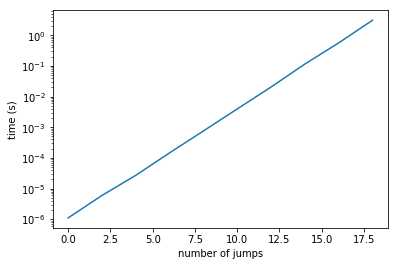

In [0]:
plt.plot(depths, times)
plt.xlabel('number of jumps')
plt.ylabel('time (s)')
plt.yscale('log');

For practical use cases, phone numbers are only about 10 digits long, so $N$ is relatively small and the overall runtime is still acceptable despite this poor scaling.

In [0]:
%time leaves = find_leaves(3, 10)
len(leaves), list(map(lambda x: ''.join(map(str, x)), leaves))[:5]

Wall time: 6 ms


(3728,
 ['34949494949', '34949494943', '34949494940', '34949494929', '34949494927'])

It's probably possible to improve the runtime further at the expense of not being able to list the generated numbers (e.g., using memoization to avoid repeated re-exploration of "equivalent" nodes of the tree, saving only the total number of unique dialable numbers), but given the short length of typical phone numbers and the potential extra utility of an implementation that also lists the dialable numbers, we will stop here.